# Exploratory Data Analysis & Customer Segmentation

In this notebook we analyze the orders data for January 2021(excluding Athens and Thessaloniki).
In the first part, we explore in high level the data, trying to idendify trends and correlations, which can give us useful insights for further analysis. Of course always the very first step is to clean the data (search for duplicates and null).

In the second part we proceed with the customer segmentation using the K-means clustering algo.

So, let's start!!!


In [1]:
# Import packages for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (6, 4)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D # 3d plot
from termcolor import colored as cl
import calendar
list(calendar.day_name)


#import packages for clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics 
from scipy.spatial.distance import cdist



In [2]:
#import the data files extraced with SQL as dataframes
raw_data= pd.read_csv('efood_raw_data.csv')
filtered_data= pd.read_csv('efood_frequencies.csv')

In [3]:
#num of columns, and datatypes
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        400000 non-null  int64  
 1   brand           400000 non-null  object 
 2   submit_dt       400000 non-null  object 
 3   user_id         400000 non-null  int64  
 4   shop_id         400000 non-null  int64  
 5   city            400000 non-null  object 
 6   cuisine_parent  400000 non-null  object 
 7   basket          400000 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 24.4+ MB


order_id: The unique identification code number of the order
brand: always efood
submit_dt: Date and Time the order was submitted
shop_id: the unique identification code number of the shop
city: the city name of the order placement
cuisine_parent: the type of cuisine, 9 different types
basket: amount of the order

In [4]:
#remove duplicates if any
raw_data=raw_data.drop_duplicates()

In [5]:
print('Number of orders: ' + str(len(raw_data['order_id'])))
print('Number of customers: ' + str(len(raw_data['user_id'].unique())))
print('Total amount: ' + str(raw_data['basket'].sum()))
print('Avg amount per customer:' + str(raw_data['basket'].sum()/len(raw_data['user_id'].unique())))
print('Avg number of orders per customer: ' + str(len(raw_data['order_id'])/len(raw_data['user_id'].unique())))

Number of orders: 400000
Number of customers: 162954
Total amount: 3489280.86
Avg amount per customer:21.412673883427225
Avg number of orders per customer: 2.454680461970863


In [6]:
#create new colums based on the submit date  
raw_data['datetime'] = pd.to_datetime(raw_data['submit_dt'])
raw_data['submit_hour'] = raw_data.datetime.dt.hour
raw_data['submit_day'] = raw_data.datetime.dt.day
raw_data['submit_weekday'] = raw_data.datetime.dt.weekday
raw_data['submit_weekday'] = raw_data['submit_weekday'].apply(lambda x: calendar.day_name[x])
weekcount = raw_data.groupby(['submit_hour','submit_weekday'],as_index=False).count()[['submit_hour','submit_weekday','order_id']]
cuisinecount = raw_data.groupby(['submit_hour','cuisine_parent'],as_index=False).count()[['submit_hour','order_id','cuisine_parent']]
cuisineday= raw_data.groupby(['submit_weekday','cuisine_parent'],as_index=False).count()[['submit_weekday','order_id','cuisine_parent']]
cuisinecity= raw_data.groupby(['city','cuisine_parent'],as_index=False).count()[['city','order_id','cuisine_parent']]
user_prefers= raw_data.groupby(['user_id'],as_index=False).agg({'order_id':'count', 'cuisine_parent':'unique'})

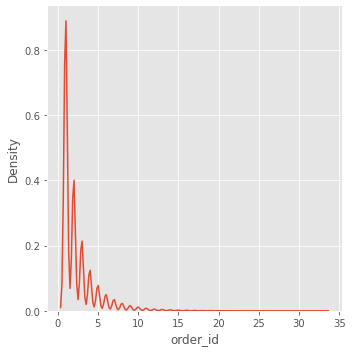

In [7]:
#check the desnity of the orders per customer
sns.displot(user_prefers, x="order_id", kind="kde")

In [8]:
# create a list of our conditions
conditions = [
    (user_prefers['order_id'] <= 1),
    (user_prefers['order_id'] > 1) & (user_prefers['order_id']<= 2),
    (user_prefers['order_id'] > 2) & (user_prefers['order_id']<= 10),
    (user_prefers['order_id']> 10)
    ]

# create a list of the values we want to assign for each condition
values = ['One time', 'Ordered a couple of times', 'Ordered less than 10', 'Ordered more than 10']

# create a new column and use np.select to assign values to it using our lists as arguments
user_prefers['frequency_type'] = np.select(conditions, values)

Text(0, 0.5, '')

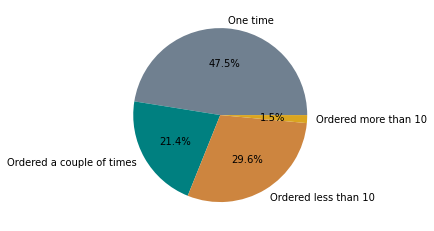

In [9]:
#group cutomers how often do they ordered 
user_prefers_per= user_prefers.groupby("frequency_type")["user_id"].count()
colors = ['#708090','#008080','#cd853f','#daa520']
user_prefers_per.plot.pie(autopct="%.1f%%", colors=colors)
plt.axes().set_ylabel('')


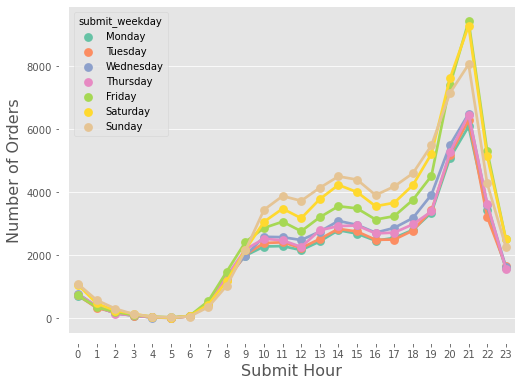

In [10]:
# number of orders placed each hour per day
#The peak of orders is around 9 in the evening, the trend is the same for all the days, 
#and finally higher number of orders are on Friday,and weekends

plt.figure(figsize=(8,6))
sns.pointplot(x='submit_hour',y='order_id',data=weekcount,kind='point',hue='submit_weekday',hue_order=list(calendar.day_name),palette="Set2")
plt.xlabel('Submit Hour',fontsize=16)
plt.ylabel('Number of Orders',fontsize=16)
sns.despine(offset=10, trim=True);

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

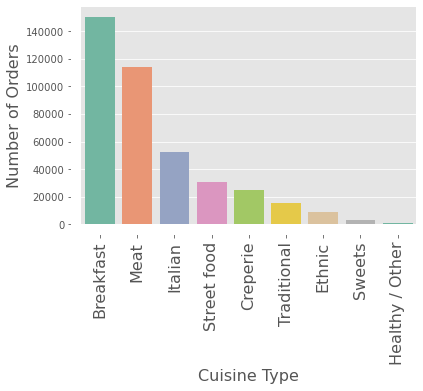

In [11]:
# number of orders placed for each cuisine type
#breakfast has the higher number of orders
#healthy/other the least

sns.countplot(raw_data.cuisine_parent,order = raw_data.cuisine_parent.value_counts().index, palette="Set2")
plt.xlabel('Cuisine Type',fontsize=16)
plt.ylabel('Number of Orders',fontsize=16)
sns.despine(offset=10, trim=True)
plt.xticks(rotation='vertical',fontsize=16)

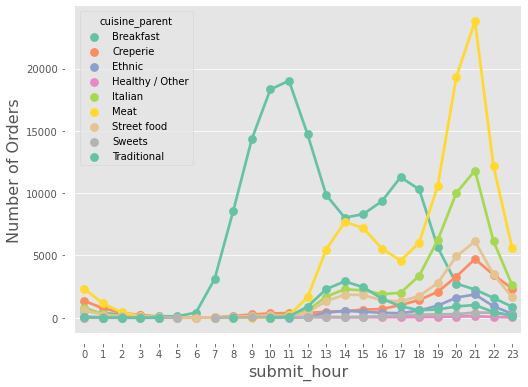

In [12]:
# number of orders placed each hour per cuisine type
#The peak of orders is around 9 in the evening for all types except of breakfast, 
#breakfast has a global peak at 11 and a anothe local peak at 5 in the afternoon
plt.figure(figsize=(8,6))
sns.pointplot(x='submit_hour',y='order_id',data=cuisinecount,kind='point',hue='cuisine_parent', palette='Set2')
plt.xlabel('submit_hour',fontsize=16)
plt.ylabel('Number of Orders',fontsize=16)
sns.despine(offset=10, trim=True)

# Segmentation Part
Using the data extracted by the second query, and the K-means cluster algo, we cluster the customers based on their frequency and the averge order value they spend.

In [13]:
#keep only the frequency and order value columns and set as index the user id
filtered= filtered_data[['user_id', 'order_value', 'frequency']]
filtered.set_index('user_id', inplace = True)

In [14]:
#Center the values around 0 with a standard deviation of 1.
df_normalized = (filtered - filtered.mean()) / filtered.std()

In [15]:
# Calculate Silhouette coefficients for different k
#Silhouette coefficient is a metric used to estimate the godness of clustering, closer to 1 the values the better.
for n_cluster in [2, 3, 4, 5, 6, 7, 8]:
    kmeans = KMeans(n_clusters=n_cluster,
                    max_iter=400,
                    n_init=20).fit(df_normalized[['order_value',
                                                  'frequency']])
    silhouette_avg = silhouette_score(df_normalized[['order_value',
                                                     'frequency']],
                                      kmeans.labels_) 
    print('Silhouette coefficient for %i clusters: %0.3f' % (n_cluster, silhouette_avg))

Silhouette coefficient for 2 clusters: 0.519
Silhouette coefficient for 3 clusters: 0.501
Silhouette coefficient for 4 clusters: 0.439
Silhouette coefficient for 5 clusters: 0.457
Silhouette coefficient for 6 clusters: 0.423
Silhouette coefficient for 7 clusters: 0.434
Silhouette coefficient for 8 clusters: 0.397


In [29]:
#Elbow method validates the number of clusters, running k-means algo for a range of values k and computes:
# a) distortion: the avg of the squared distances from the cluster centres of the respective clusters
# b) Inertia: the sum of squared distances of samples to their closte cluster centre.
def elbow(K,dataframe, features_list):
    distortions = [] 
    inertias = []

    for k in K: 
        kmeanModel = KMeans(n_clusters=k,
                        max_iter=400,
                        n_init=20).fit(dataframe[features_list]) 
        kmeanModel.fit(dataframe[features_list])
        distortions.append(sum(np.min(cdist(dataframe[features_list],
                                        kmeanModel.cluster_centers_,
                                        'euclidean'),axis=1)) / dataframe[features_list].shape[0]) 
        inertias.append(kmeanModel.inertia_)
        
        
    return(distortions,inertias)
    
    

In [17]:
distortions, inertias= elbow(range(1, 11),df_normalized, ['order_value',
                                                  'frequency'])

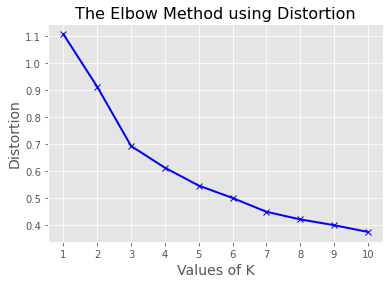

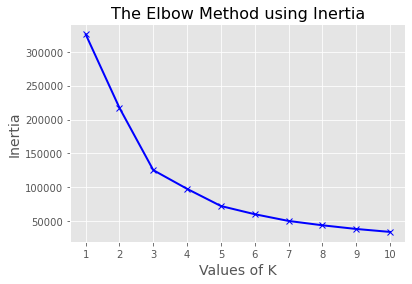

In [18]:
#plot the distortions and inetrias for the different k
K=range(1, 11)
# Plot distortions
plt.plot(K, distortions, 'bx-',  linewidth=2, color='blue') 
plt.xlabel('Values of K', fontsize=14) 
plt.ylabel('Distortion', fontsize=14) 
plt.title('The Elbow Method using Distortion', fontsize=16) 
plt.xticks(np.arange(1, 11))
plt.show()

# Plot inertias
plt.plot(K, inertias, 'bx-', linewidth=2, color='blue') 
plt.xlabel('Values of K', fontsize=14) 
plt.ylabel('Inertia', fontsize=14) 
plt.title('The Elbow Method using Inertia', fontsize=16) 
plt.xticks(np.arange(1, 11))
plt.show()

From the above plots we select K=3 because the Silhouette coefficient is relatively high and inertia and distortion do not change significantly with increasing the number of clusters.

In [19]:
# Build k-means clustering model
kmeans = KMeans(n_clusters=3,
                max_iter=400,
                n_init=20).fit(df_normalized[['order_value','frequency']])

# Get centres of the clusters
df_cluster_centres = pd.DataFrame(kmeans.cluster_centers_, columns=['order_value','frequency'])
df_cluster_centres['Cluster'] = df_cluster_centres.index

# Mark each customer with its cluster
df_three_clusters = df_normalized[['order_value','frequency']].copy(deep=True)
df_three_clusters['Cluster'] = kmeans.labels_

In [20]:
df_three_clusters['Cluster'].value_counts()

0    109294
1     33031
2     20629
Name: Cluster, dtype: int64

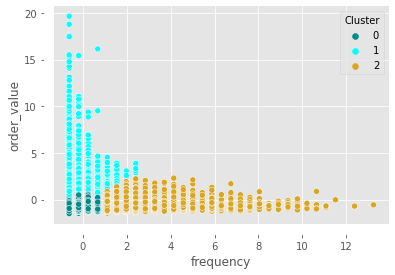

In [22]:
#From the clusters plot we can see the characteristics of the 3 groups:
#the 0 cluster contains the custoers which spent a lot but don't order frequent
#the 1 cluster contains the customers that don't spens a lot and also are not loyal customers
#the 2 cluster contains the loyal customers that order frequent but make small amount orders.
df_three_clusters['user_id'] = df_three_clusters.index
sns.scatterplot(data=df_three_clusters, x='frequency', y='order_value',hue='Cluster', palette= ["#008b8b", "#00ffff", "#daa520"])
sns.despine(offset=10, trim=True)

The most interesting group for the campaign is the cluster 2, as coffee is an inexpensive product but requires higher frequency.

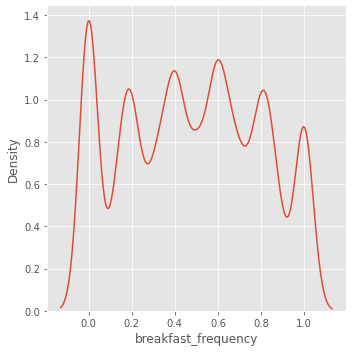

In [23]:
# Now lets check the breakfast frequency of the customers in our target group (cluster 2)
high_frequency_cluster = df_three_clusters.loc[df_three_clusters['Cluster'] == 2]
selected= pd.DataFrame(filtered_data.loc[filtered_data['user_id'].isin(high_frequency_cluster.index)])
sns.displot(selected, x="breakfast_frequency", kind="kde")               

In [24]:
#As a final step we can filter and keep the users with higher than 0 breakfast frequency
#thus our final group will be the following
selected= selected[selected['breakfast_frequency']>0]
print('Number of customers in the target group for coffee: ' + str(len(selected)))

Number of customers in the target group for coffee: 17582


In [25]:
#Extract generic info from the target group
selected_raw= pd.DataFrame(raw_data.loc[raw_data['user_id'].isin(selected['user_id'])])
print('Number of Customers in the target group: ' + str(len(selected_raw['user_id'].unique())))
print('Number of Orders: ' + str(len(selected_raw)))
print('Total amount: ' + str(selected_raw['basket'].sum()))

Number of Customers in the target group: 17582
Number of Orders: 132137
Total amount: 888541.9900000001


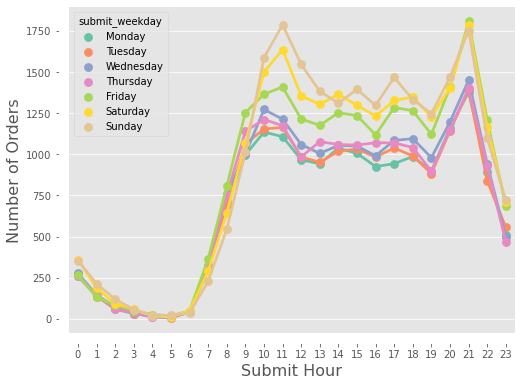

In [26]:
#visualize the number of orders per hour of the target customers
weekcount_2= selected_raw.groupby(['submit_hour','submit_weekday'],as_index=False).count()[['submit_hour','submit_weekday','order_id']]
plt.figure(figsize=(8,6))
sns.pointplot(x='submit_hour',y='order_id',data=weekcount_2,kind='point',hue='submit_weekday',hue_order=list(calendar.day_name),palette="Set2")
plt.xlabel('Submit Hour',fontsize=16)
plt.ylabel('Number of Orders',fontsize=16)
sns.despine(offset=10, trim=True);

# Optional
Just for my curiosity, lets apply the k-means with the extra feature of the breakfast_frequency.

In [27]:
##### using more features
filtered_2= filtered_data[['user_id', 'order_value', 'frequency', 'breakfast_frequency']]
filtered_2.set_index('user_id', inplace = True)
df_normalized_2 = (filtered_2 - filtered_2.mean()) / filtered_2.std()

In [28]:
# Calculate Silhouette coefficients for different k
for n_cluster in [2, 3, 4, 5, 6, 7, 8]:
    kmeans = KMeans(n_clusters=n_cluster,
                    max_iter=400,
                    n_init=20).fit(df_normalized_2[['order_value',
                                                  'frequency', 'breakfast_frequency']])
    silhouette_avg = silhouette_score(df_normalized_2[['order_value',
                                                     'frequency', 'breakfast_frequency']],
                                      kmeans.labels_) 
    print('Silhouette coefficient for %i clusters: %0.3f' % (n_cluster, silhouette_avg))

Silhouette coefficient for 2 clusters: 0.429
Silhouette coefficient for 3 clusters: 0.465
Silhouette coefficient for 4 clusters: 0.458
Silhouette coefficient for 5 clusters: 0.441
Silhouette coefficient for 6 clusters: 0.432
Silhouette coefficient for 7 clusters: 0.433
Silhouette coefficient for 8 clusters: 0.450


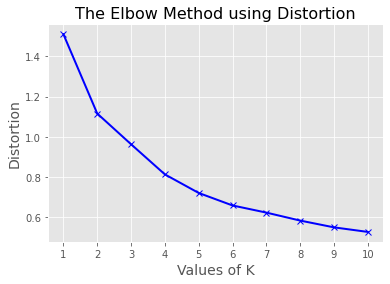

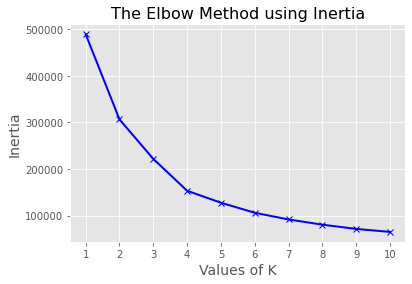

In [30]:
distortions_2, inertias_2= elbow(range(1, 11),df_normalized_2, ['order_value',
                                                  'frequency', 'breakfast_frequency']) 

K=range(1, 11)
# Plot distortions
plt.plot(K, distortions_2, 'bx-',  linewidth=2, color='blue') 
plt.xlabel('Values of K', fontsize=14) 
plt.ylabel('Distortion', fontsize=14) 
plt.title('The Elbow Method using Distortion', fontsize=16) 
plt.xticks(np.arange(1, 11))
plt.show()

# Plot inertias
plt.plot(K, inertias_2, 'bx-', linewidth=2, color='blue') 
plt.xlabel('Values of K', fontsize=14) 
plt.ylabel('Inertia', fontsize=14) 
plt.title('The Elbow Method using Inertia', fontsize=16) 
plt.xticks(np.arange(1, 11))
plt.show()

In [31]:
# Build k-means clustering model
kmeans_2 = KMeans(n_clusters=4,
                max_iter=400,
                n_init=20).fit(df_normalized_2[['order_value','frequency', 'breakfast_frequency']])

# Get centres of the clusters
df_cluster_centres_2 = pd.DataFrame(kmeans_2.cluster_centers_, columns=['order_value','frequency', 'breakfast_frequency'])
df_cluster_centres_2['Cluster'] = df_cluster_centres_2.index

# Mark each customer with its cluster
df_clusters_2 = df_normalized_2[['order_value','frequency', 'breakfast_frequency']].copy(deep=True)
df_clusters_2['Cluster'] = kmeans_2.labels_

In [32]:
#We select the cluster 3 cause is characterised by high breakfast frequency, low order value and moderate total frequency.
#This is an alternative target group that we can select.
df_cluster_centres_2

,order_value,frequency,breakfast_frequency,Cluster
0,-0.610988,-0.177910,1.376564,0
1,1.886082,-0.410442,-0.671959,1
2,-0.414639,2.315706,0.448181,2
3,-0.099748,-0.283096,-0.673192,3


In [ ]:
#This target group contains 44k of customers
df_clusters_2['Cluster'].value_counts()

In [ ]:
fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig, 
            rect = [0, 0, .95, 1], 
            elev = 60, 
            azim = 134)

plt.cla()
ax.scatter(df_clusters_2['order_value'], df_clusters_2['frequency'], df_clusters_2['breakfast_frequency'], 
           c = df_clusters_2['Cluster'], 
           s = 15, 
           cmap = 'Set3', 
           alpha = 0.5, 
           edgecolor = 'darkgrey')
ax.set_xlabel('order value', 
              fontsize = 16)
ax.set_ylabel('frequency', 
              fontsize = 16)
ax.set_zlabel('breakfast frequency', 
              fontsize = 16)

plt.savefig('3d_plot.png')
plt.show()

# Summary
We applied k-means clustering to understand the segments of customers using the January Orders

W used as features the frequency and the order value

Using Elbow method and Silhouette coefficient, we found the optimal number of segments, which is 3

We further look the different characteristics of each segment, in order to select the most valuable for the coffee campaign.

We choose the segment of customers with high frequency and low order value, and extract the trends of this group.
